[![](https://colab.research.google.com/assets/colab-badge.svg "Open in Colab button")](https://colab.research.google.com/github/thinkingmachines/geowrangler/blob/master/notebooks/15_polygon_fill.ipynb)

In [ ]:
#| default_exp gridding_utils.polygon_fill

In [ ]:
%reload_ext autoreload
%autoreload 2

In [ ]:
#| include: false
#| no_test
![ -e /content ] && pip install -Uqq geowrangler

In [ ]:
#| export
from typing import List, Tuple, Set, Optional, Dict, Union

import numpy as np
import pandas as pd
import geopandas as gpd
import polars as pl

In [ ]:
#| hide
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from shapely.geometry import Polygon, MultiPolygon

## Overview

We will go over utility functions that leverage these 2 algorithms for filling in pixels in polygons fast:

1. [Voxel Traversal Algorithm](https://github.com/cgyurgyik/fast-voxel-traversal-algorithm/blob/master/overview/FastVoxelTraversalOverview.md): We use this for filling in pixels along the polygon boundary. 2D voxel traversal is used for every line segment of the polygon boundary.
2. [Scanline Fill Algorithm](https://www.educative.io/answers/what-is-scanline-fill-algorithm): We use this for filling in pixels in the polygon interior.

The utility functions are currently used in [FastSquareGridGenerator](https://geowrangler.thinkingmachin.es/grids.html#fastsquaregridgenerator) and [FastBingTileGridGenerator](https://geowrangler.thinkingmachin.es/grids.html#fastbingtilegridgenerator)

At the end of this notebook, there's a section for error correction using off-boundary pixels.

### In a nutshell, how do we speed up polygon fill?

1. Translate polygons from geographic coordinates (epsg:4326, epsg:3857) to pixel coordinates (integers only)
2. <b>Use the fast polygon fill algorithms to get the polygon pixels and off-boundary pixels (focus of this notebook)</b>
3. Translate pixels back from pixel coordinates to geographic coordinates (square polygons)
4. Perform off-boundary pixel error correction

This notebook focuses on the fast polygon fill algorithms, while the translation functions and error correction proper are found in [FastSquareGridGenerator](https://geowrangler.thinkingmachin.es/grids.html#fastsquaregridgenerator) and [FastBingTileGridGenerator](https://geowrangler.thinkingmachin.es/grids.html#fastbingtilegridgenerator).

In [ ]:
polygon_test_cases = {
    "Square": [(0, 0), (10, 0), (10, 10), (0, 10)],
    "Triangle": [(0, 0), (10, 0), (5, 10)],
    "Right Triangle": [(0, 0), (10, 0), (0, 10)],
    "Pentagon": [(2, 0), (8, 0), (10, 6), (5, 10), (0, 6)],
    "Star": [
        (6, 2),
        (8, 8),
        (12, 8),
        (9, 12),
        (11, 18),
        (6, 14),
        (1, 18),
        (3, 12),
        (0, 8),
        (4, 8),
    ],

    "Complex Shape 1": [(0, 0), (5, 2), (3, 5), (8, 8), (5, 10), (0, 7)],
    "Complex Shape 2": [
        (0, 0),
        (2, 6),
        (4, 10),
        (6, 8),
        (8, 12),
        (10, 4),
        (12, 2),
        (8, 0),
    ],
    "Complex Shape 3": [(2, 3), (5, 3), (6, 6), (3, 7), (1, 5)],
    "Complex Shape 4": [(1, 1), (2, 5), (4, 3), (6, 7)],
    "Complex Shape 5": [(1, 2), (3, 6), (5, 5), (7, 4), (9, 5), (11, 2)],
}

In [ ]:
#| hide
def plot_polygon(
    ax: plt.Axes,
    vertices: List[Tuple[int,int]],
    pixels: Optional[set] = None,
    figsize: tuple = (4, 4),
):
    vertices_x = [x for (x,y) in vertices]
    vertices_y = [y for (x,y) in vertices]
    
    ax.plot(vertices_x, vertices_y, "b-", markersize=5)
    # to close off the polygon
    ax.plot([vertices_x[-1], vertices_x[0]], [vertices_y[-1], vertices_y[0]], "b-")

    if pixels is not None:
        for x, y in pixels:
            rect = patches.Rectangle(
                xy=(x - 0.5, y - 0.5),
                width=1,
                height=1,
                linewidth=1,
                edgecolor="black",
                facecolor="r",
                alpha=0.6,
            )
            ax.add_patch(rect)

def plot_all_polygons(
    polygon_vertices_dict: Dict[str, List[Tuple[int, int]]], 
    polygon_pixels_dict: Dict[str, set], 
    n_imgs_per_row: int = 3,
):
    n = len(polygon_vertices_dict)
    rows = (n + n_imgs_per_row - 1) // n_imgs_per_row 
    fig, axes = plt.subplots(nrows=rows, ncols=n_imgs_per_row, figsize=(4 * n_imgs_per_row, 4 * rows))

    if n_imgs_per_row == 1:
        axes = [axes]  
    
    # Flattening the axes for easier iteration, especially for n_imgs_per_row = 1
    axes_flat = axes.flatten()

    # Iterate over each polygon and its corresponding pixels
    for ax, (name, vertices) in zip(axes_flat, polygon_vertices_dict.items()):
        pixels = polygon_pixels_dict.get(name, set())
        plot_polygon(ax, vertices, pixels)
        title = f"{name}\n{len(pixels)} pixels"
        ax.set_title(title)
        ax.axis('equal')
    
    for ax in axes_flat[n:]:
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()

## Voxel Traversal

We use the 2D voxel traversal algorithm to fill in pixels between two points.

In [ ]:
#| export

def voxel_traversal_2d(
    start_vertex: Tuple[int, int], 
    end_vertex: Tuple[int, int],
    debug: bool = False, # if true, prints diagnostic info for the algorithm  
) -> Dict[str,List[Tuple[int, int]]]:
    """
    Returns all pixels between two points as inspired by Amanatides & Woo's “A Fast Voxel Traversal Algorithm For Ray Tracing” 
    
    Implementation adapted from https://www.redblobgames.com/grids/line-drawing/ in the supercover lines section

    This also returns the off-diagonal pixels that can be useful for correcting errors at the corners of polygons during polygon fill
    """

    # Setup initial conditions
    x1, y1 = start_vertex
    x2, y2 = end_vertex

    direction_x = 1 if x2 > x1 else -1
    direction_y = 1 if y2 > y1 else -1

    result = {"line_pixels":[], "off_diagonal_pixels":[]}
    
    # Single point
    if (x1 == x2) and (y1 == y2):
        pixels = [(x1,y1)]
        result["line_pixels"].extend(pixels)
        return result

    # Vertical line
    elif x1 == x2:
        pixels = [(x1, y) for y in range(y1, y2 + direction_y, direction_y)]
        result["line_pixels"].extend(pixels)
        return result

    # Horizontal line
    elif y1 == y2:
        pixels = [(x, y1) for x in range(x1, x2 + direction_x, direction_x)]
        result["line_pixels"].extend(pixels)
        return result

    dy = y2 - y1
    dx = x2 - x1

    pixel_x, pixel_y = x1, y1
    pixels = [(pixel_x, pixel_y)]
    off_diagonal_pixels = []

    is_finished = False

    if debug:
        print(f"\nTraversing from ({x1},{y1}) to ({x2},{y2})")

    ix = 0
    iy = 0

    nx = abs(dx)
    ny = abs(dy)
    max_steps = (nx+ny)
    n_steps = 0
    while not is_finished:
        # this prevents infinite loops
        n_steps += 1
        if n_steps > max_steps:
            raise Exception(
                f"Traversal has exceeded steps limit {max_steps:,}. Please recheck inputs"
            )

        decision = (1+2*ix)*ny - (1+2*iy)*nx
        if decision == 0:

            off_diagonal_pixels.append((pixel_x + direction_x, pixel_y))
            off_diagonal_pixels.append((pixel_x, pixel_y + direction_y))
            
            # diagonal step
            pixel_x += direction_x
            pixel_y += direction_y
            ix += 1
            iy += 1
        elif decision < 0:
            # horizontal step
            pixel_x += direction_x
            ix += 1
        else:
            # vetical step
            pixel_y += direction_y
            iy += 1

        pixels.append((pixel_x, pixel_y))

        if debug:
            print(
                f"Next tile coords are ({pixel_x}, {pixel_y})"
            )

        # checks to see if the loop is finished
        if direction_x == 1:
            is_x_finished = pixel_x >= x2
        elif direction_x == -1:
            is_x_finished = pixel_x <= x2

        if direction_y == 1:
            is_y_finished = pixel_y >= y2
        elif direction_y == -1:
            is_y_finished = pixel_y <= y2

        if is_x_finished and is_y_finished:
            break

    result = {"line_pixels":pixels, "off_diagonal_pixels":off_diagonal_pixels}
    return result

Voxel traversal is used on every line segment to fill the polygon boundary.

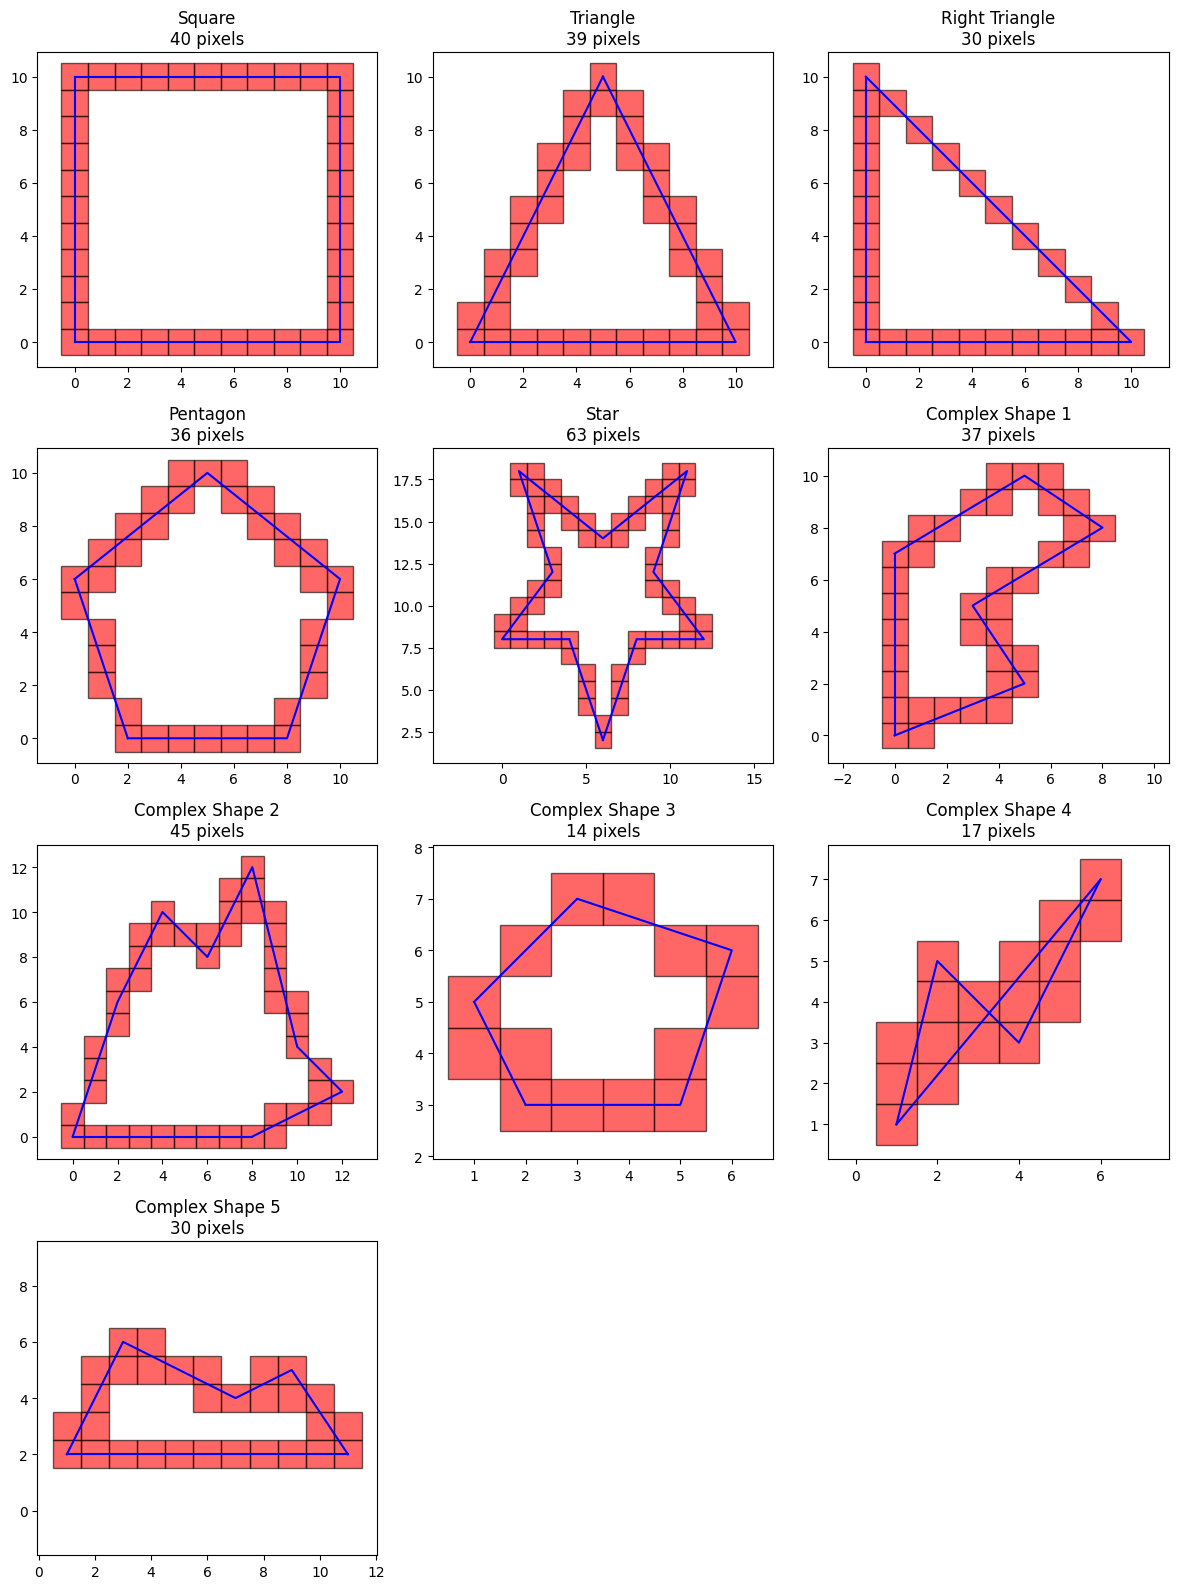

In [ ]:
polygon_pixels = {}
for test_polygon_name, vertices in polygon_test_cases.items():
    offset_vertices = vertices[1:] + vertices[:1]

    pixels = set()
    for start_vertex, end_vertex in zip(vertices, offset_vertices):
        pixels.update(voxel_traversal_2d(start_vertex, end_vertex)["line_pixels"])

    polygon_pixels[test_polygon_name] = pixels
    
plot_all_polygons(polygon_test_cases, polygon_pixels)

## Scanline Fill Algorithm

We use the scanline fill algorithm to fill in pixels within the polygon boundary.

In [ ]:
#| exporti
def interpolate_x(
    start_vertex: Tuple[int, int],
    end_vertex: Tuple[int, int],
    y: int,
) -> float:
    """Interpolate x value for a given y along the line segment defined by start_vertex and end_vertex."""
    x1, y1 = start_vertex
    x2, y2 = end_vertex
    if y1 == y2:
        # case when there is a horizontal line segment
        raise ValueError(f"The y value of the 2 vertices should not be the same")

    inverse_slope = (x2 - x1) / (y2 - y1)
    interpolated_x = x1 + (y - y1) * inverse_slope
    return interpolated_x

In [ ]:
#| export
def scanline_fill(
    vertices: List[Tuple[int,int]], # list of polygon vertices in order (either clockwise or counterclockwise)
    debug: bool = False, # if true, prints diagnostic info for the algorithm  
) -> Set[Tuple[int,int]]:
    """Returns all pixels within the interior of a polygon defined by vertices"""
    
    offset_vertices = vertices[1:] + vertices[:1]

    if not vertices:
        return set()
    
    if len(vertices) == 1:
        return set(vertices)

    # Calculate the bounding box for the polygon
    min_y, max_y = min(y for x, y in vertices), max(y for x, y in vertices)

    filled_pixels = set()
    # Process each horizontal scanline within the bounding box
    for scanline_y in range(min_y, max_y + 1):
        intersection_points = []

        # Find intersections of the polygon with the current scanline
        for start_vertex, end_vertex in zip(vertices, offset_vertices):
            start_x, start_y = start_vertex
            end_x, end_y = end_vertex

            if (end_y < scanline_y <= start_y) or (start_y < scanline_y <= end_y):
                # Calculate x-coordinate of intersection
                intersection_x = interpolate_x(start_vertex, end_vertex, scanline_y)
                intersection_points.append(intersection_x)

        # Fill pixels between pairs of intersections
        if intersection_points:
            intersection_points.sort()

            filled_pixels_in_row = set()
            for start_x, end_x in zip(
                intersection_points[::2], intersection_points[1::2]
            ):
                start_x, end_x = int(round(start_x)), int(round(end_x))

                _filled_pixels_in_row = [
                    (x, scanline_y) for x in range(start_x, end_x + 1)
                ]
                filled_pixels_in_row.update(_filled_pixels_in_row)

            filled_pixels.update(filled_pixels_in_row)

        if debug:
            print(f"Scanline y = {scanline_y}, Intersections: {intersection_points}")
    
    return filled_pixels


We use scanline fill on every set of vertices. Notice that the scanline can fill parts of the boundary as well, but it doesn't capture the entire boundary.

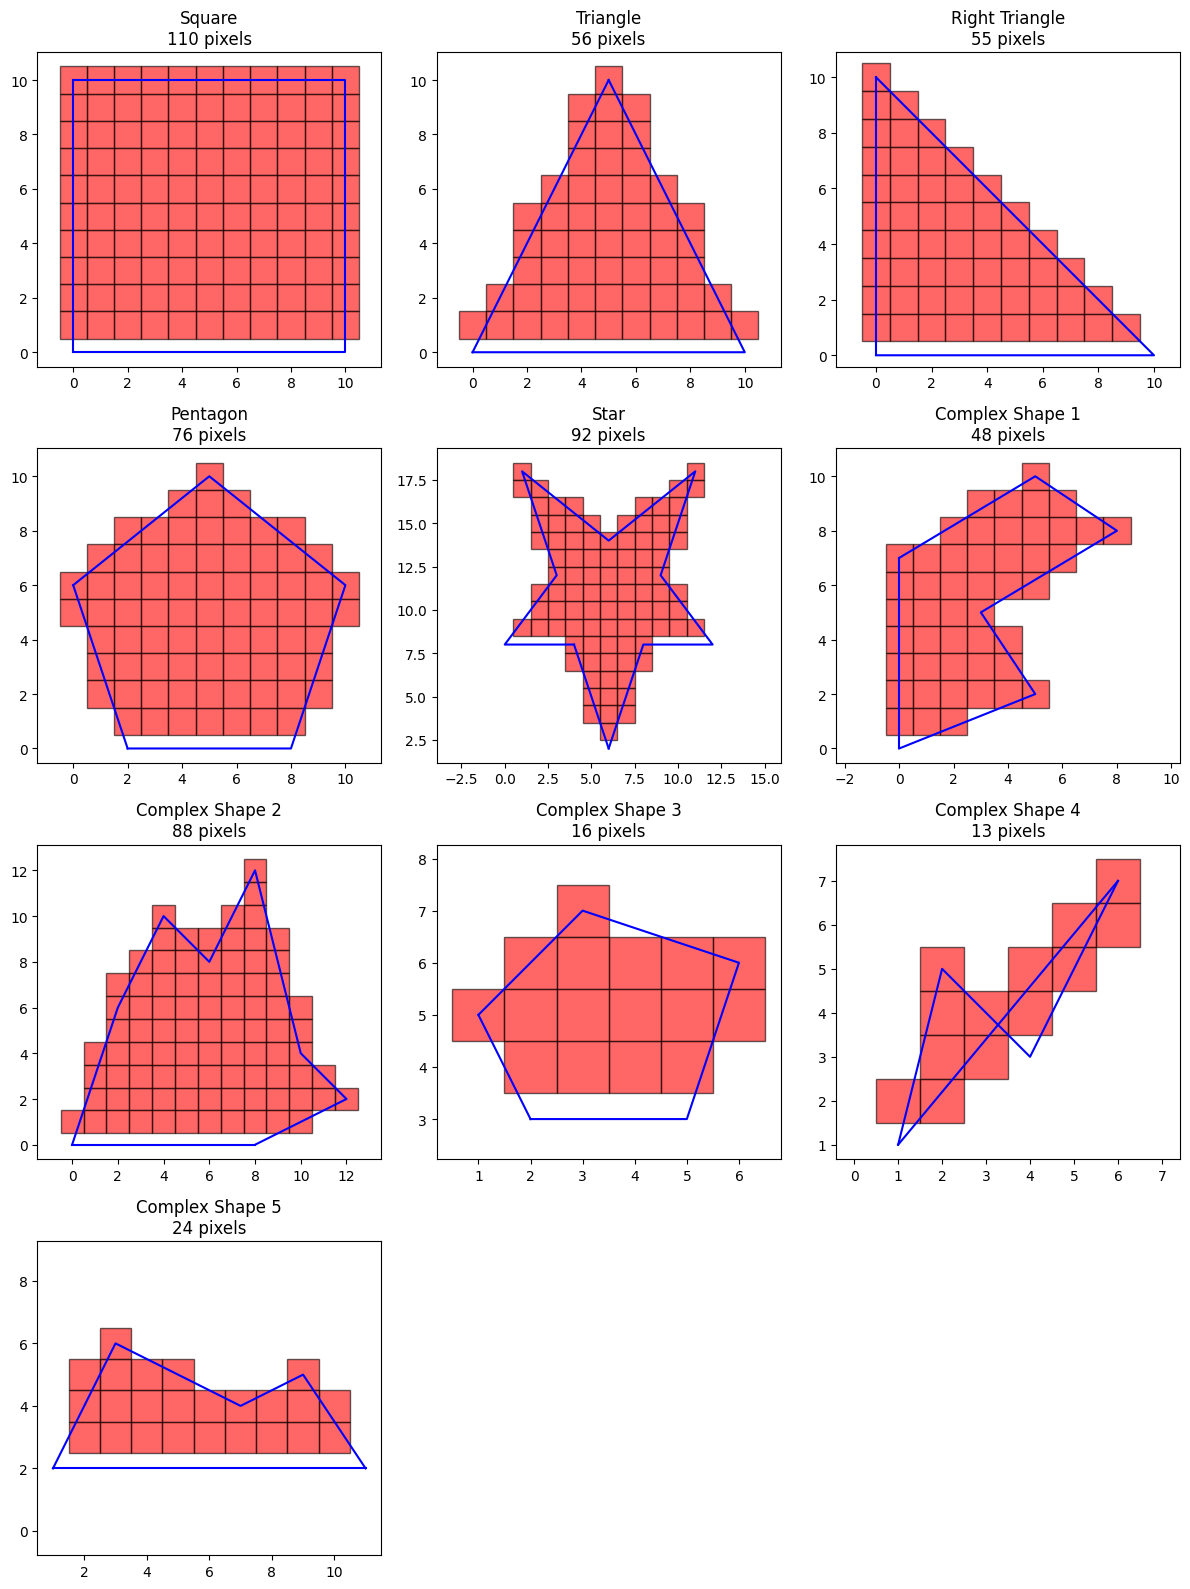

In [ ]:
polygon_pixels = {}
for test_polygon_name, vertices in polygon_test_cases.items():
    polygon_pixels[test_polygon_name] = scanline_fill(vertices)
    
plot_all_polygons(polygon_test_cases, polygon_pixels)

## Combining Voxel Traversal and Scanline Fill for our Polygon Fill Algorithm

In [ ]:
#| export

def voxel_traversal_scanline_fill(
    vertices_df: Union[pd.DataFrame,pl.DataFrame], # dataframe with x_col and y_col for the polygon vertices
    x_col: str = "x", 
    y_col: str = "y",
    debug: bool = False, # if true, prints diagnostic info for both voxel traversal and scanline fill algorithms
) -> Dict[str, Set[Tuple[int,int]]]:
    """
    Returns pixels that intersect a polygon. 
    
    This uses voxel traversal to fill the boundary, and scanline fill for the interior. All coordinates are assumed to be integers.        
    
    This also returns the off-boundary pixels that can be useful for correcting errors at the corners of polygons during polygon fill
    """

    vertices = list(zip(vertices_df[x_col].to_list(), vertices_df[y_col].to_list()))
    offset_vertices = vertices[1:] + vertices[:1]

    polygon_pixels = set()
    off_boundary_pixels = set()

    for start_vertex, end_vertex in zip(vertices, offset_vertices):
        voxel_traversal_results = voxel_traversal_2d(start_vertex, end_vertex, debug)
        polygon_pixels.update(voxel_traversal_results["line_pixels"])
        off_boundary_pixels.update(voxel_traversal_results["off_diagonal_pixels"])

    polygon_pixels.update(scanline_fill(vertices, debug))

     # removing off boundary tiles that are actually in the interior 
    off_boundary_pixels = off_boundary_pixels - polygon_pixels

    result = {"polygon_pixels":polygon_pixels, "off_boundary_pixels":off_boundary_pixels}
    return result

By using both algorithms, we can fill all the pixels per polygon.

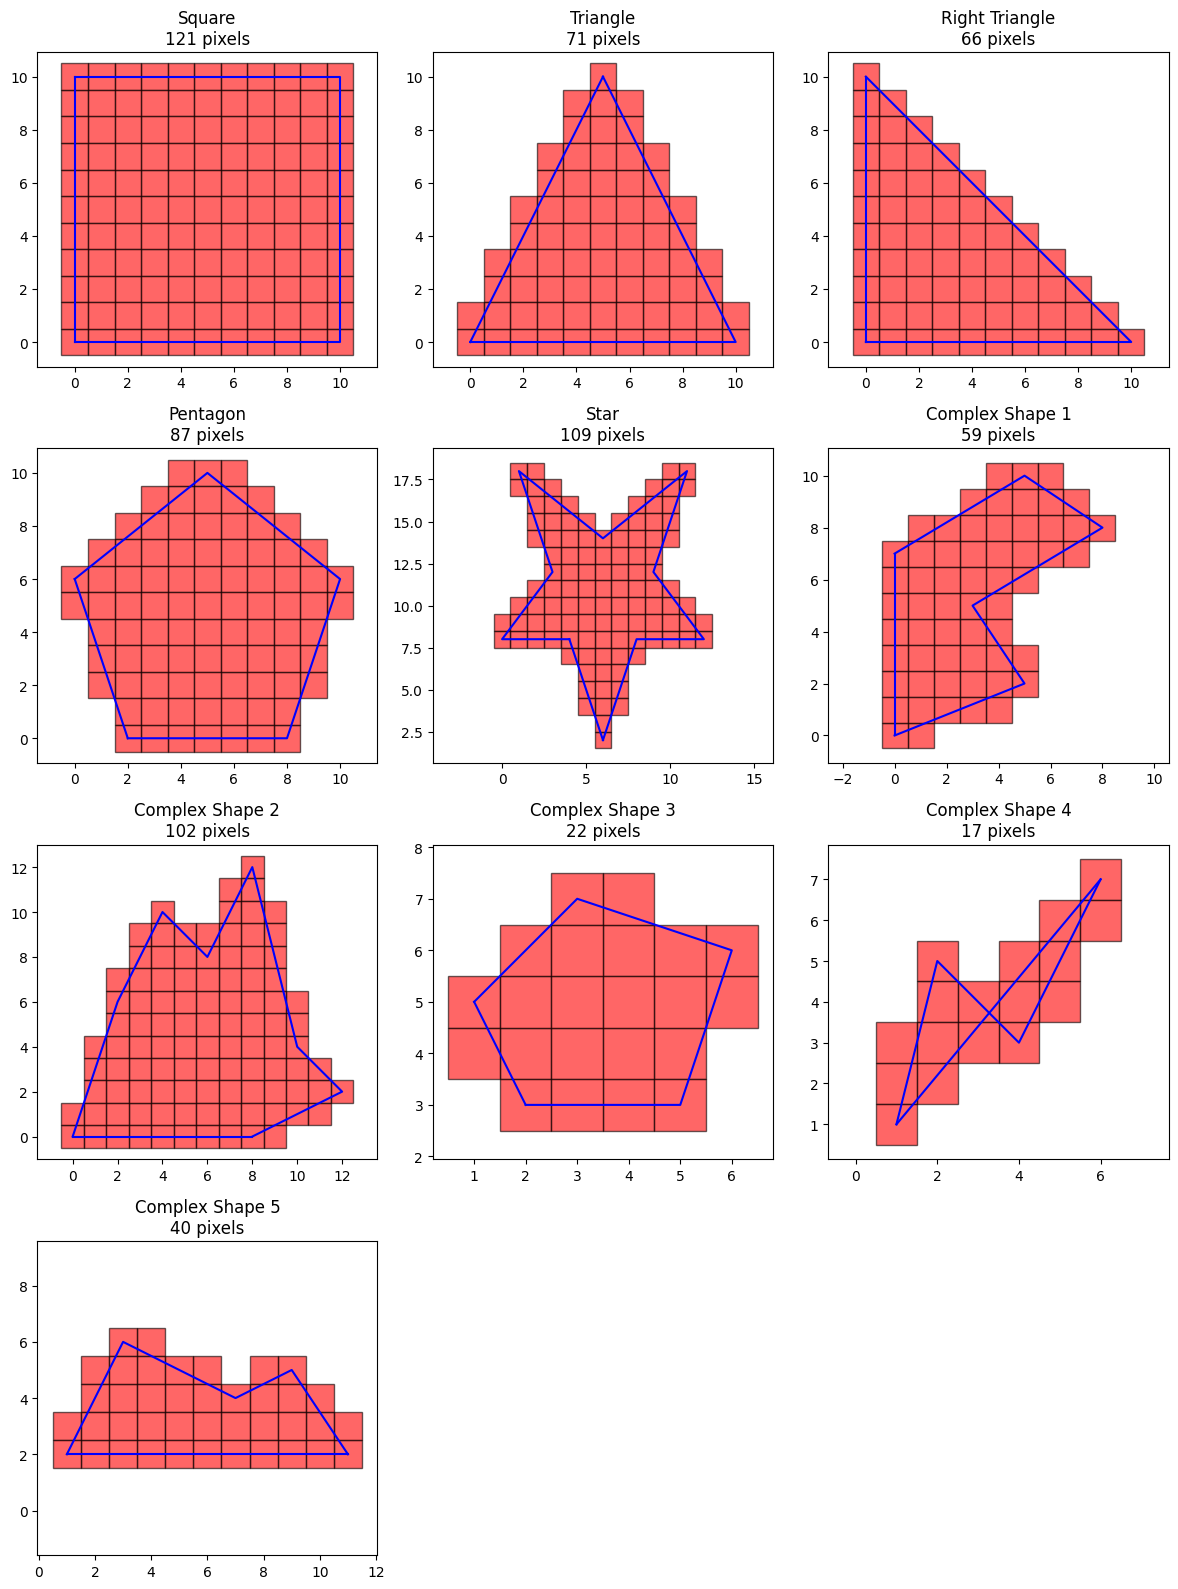

In [ ]:
polygon_pixels = {}
for test_polygon_name, vertices in polygon_test_cases.items():
    vertices_df = pd.DataFrame(vertices, columns=["x", "y"])
    polygon_pixels[test_polygon_name] = voxel_traversal_scanline_fill(vertices_df)["polygon_pixels"]
    
plot_all_polygons(polygon_test_cases, polygon_pixels)

## Putting it all together to fill multiple polygons in a GeoDataFrame

Here we build up to the `fast_polygon_fill` function that can fill in multiple polygons and MultiPolygon geometries in an AOI. This essentially means using `voxel_traversal_scanline_fill` on each individual polygon in the AOI.

In [ ]:
multipolygon_dict = {
    "Square": Polygon([(15, 0), (25, 0), (25, 10), (15, 10)]),
    "Triangle MultiPolygon": MultiPolygon(polygons = [
        Polygon([(0, 0), (10, 0), (5, 10)]), 
        Polygon([(0, 12), (10, 12), (0, 22)])],
    ),
    "Pentagon": Polygon([(17, 15), (23, 15), (25, 21), (20, 25), (15, 21)]),
}

multipolygon_gdf = gpd.GeoDataFrame(geometry=gpd.GeoSeries(multipolygon_dict))
multipolygon_gdf.index.name = "geom_name"
multipolygon_gdf = multipolygon_gdf.reset_index()
multipolygon_gdf 

,geom_name,geometry
0,Square,"POLYGON ((15 0, 25 0, 25 10, 15 10, 15 0))"
1,Triangle MultiPolygon,"MULTIPOLYGON (((0 0, 10 0, 5 10, 0 0)), ((0 12..."
2,Pentagon,"POLYGON ((17 15, 23 15, 25 21, 20 25, 15 21, 1..."


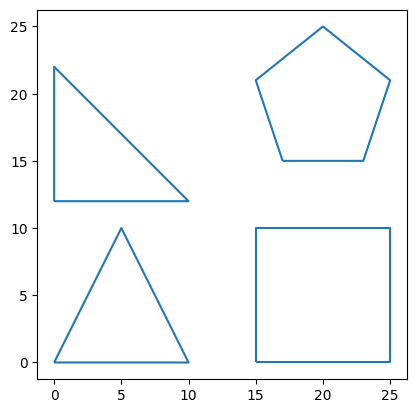

In [ ]:
multipolygon_gdf.boundary.plot()
plt.show()

### Converting `Polygons` and `MultiPolygons` to a list of vertices 

The `polygons_to_vertices` function can convert all polygons and multipolygons in a GeoDataFrame to a Polars DataFrame of vertices. This is a preparation step for `fast_polygon_fill`.

Note: It is also feasible to convert it to a Pandas DataFrame but using Polars is more efficient for vectorized translations between geographic coordinates and pixel coordinates.

In [ ]:
#| exporti
SUBPOLYGON_ID_COL =  "__subpolygon_id__"
PIXEL_DTYPE = pl.Int32

In [ ]:
#| export
def polygons_to_vertices(
    polys_gdf: gpd.GeoDataFrame, 
    unique_id_col: Optional[str] = None # the ids under this column will be preserved in the output tiles
) -> pl.DataFrame:
    
    if unique_id_col is not None:
        duplicates_bool = polys_gdf[unique_id_col].duplicated()
        if duplicates_bool.any():
            raise ValueError(
                f"""{unique_id_col} is not unique!
                Found {duplicates_bool.sum():,} duplicates"""
            )
        polys_gdf = polys_gdf.set_index(unique_id_col)
    else:
        # reset index if it is not unique
        if polys_gdf.index.nunique() != len(polys_gdf.index):
            polys_gdf = polys_gdf.reset_index(drop=True)
        unique_id_col = polys_gdf.index.name

    polys_gdf = polys_gdf.explode(index_parts=True)

    is_poly_bool = polys_gdf.type == "Polygon"
    if not is_poly_bool.all():
        raise ValueError(
            f"""
        All geometries should be polygons or multipolygons but found
        {is_poly_bool.sum():,} after exploding the GeoDataFrame"""
        )

    polys_gdf.index.names = [unique_id_col, SUBPOLYGON_ID_COL]
    vertices_df = polys_gdf.get_coordinates().reset_index()
    vertices_df = pl.from_pandas(vertices_df)

    return vertices_df

The output is a dataframe of vertices across all polygons. 

If the original coordinates are based on a geographic coordinate system such as `epsg:4326` or `epsg:3857`, then there would normally need to be an additional step to translate it from geographic coordinates to pixel coordinates. But since our sample polygons are already based on pixel coordinates, then we only need to cast the vertex coordinates `x`, `y` to an integer dtype.

In [ ]:
vertices_df = polygons_to_vertices(multipolygon_gdf, "geom_name")
vertices_df = vertices_df.cast({"x":PIXEL_DTYPE, "y":PIXEL_DTYPE})
vertices_df.head()

geom_name,__subpolygon_id__,x,y
str,i64,i32,i32
"""Square""",0,15,0
"""Square""",0,25,0
"""Square""",0,25,10
"""Square""",0,15,10
"""Square""",0,15,0


### Getting pixels within each polygon

The `fast_polygon_fill` function is generally a wrapper on `voxel_traversal_scanline_fill` to find all pixel coordinates within each polygon in the AOI. 

In [ ]:
#| export

def fast_polygon_fill(
    vertices_df: pl.DataFrame, # integer vertices of all polygons in the AOI
    unique_id_col: Optional[str] = None, # the ids under this column will be preserved in the output tiles
) -> Dict[str,pl.DataFrame]:
    
    if unique_id_col is not None:
        id_cols = [SUBPOLYGON_ID_COL, unique_id_col]
        has_unique_id_col = True
    else:
        complement_cols = ["x","y",SUBPOLYGON_ID_COL]
        unique_id_col = list(set(vertices_df.columns) - set(complement_cols))
        assert len(unique_id_col) == 1
        unique_id_col = unique_id_col[0]
        id_cols = [SUBPOLYGON_ID_COL, unique_id_col]
        has_unique_id_col = False

    for col in id_cols:
        assert col in vertices_df, f"{col} should be column in vertices_df"

    polygon_ids = vertices_df.select(id_cols).unique(maintain_order=True).rows()

    tiles_in_geom = set()
    tiles_off_boundary = set()
    for polygon_id in polygon_ids:
        subpolygon_id, unique_id = polygon_id
        filter_expr = (pl.col(SUBPOLYGON_ID_COL) == subpolygon_id) & (
            pl.col(unique_id_col) == unique_id
        )
        poly_vertices = vertices_df.filter(filter_expr)
        
        poly_vertices = poly_vertices.unique(maintain_order=True)
        voxel_traversal_results = voxel_traversal_scanline_fill(poly_vertices, x_col="x", y_col="y")
        _tiles_in_geom = voxel_traversal_results["polygon_pixels"]
        _tiles_off_boundary = voxel_traversal_results["off_boundary_pixels"]

        if has_unique_id_col:
            _tiles_in_geom = [(x, y, unique_id) for (x, y) in _tiles_in_geom]
            _tiles_off_boundary = [(x, y, unique_id) for (x, y) in _tiles_off_boundary]

        tiles_in_geom.update(_tiles_in_geom)
        tiles_off_boundary.update(_tiles_off_boundary)

    # removing off boundary tiles that are actually in the interior 
    tiles_off_boundary = tiles_off_boundary - tiles_in_geom

    schema = {"x": PIXEL_DTYPE, "y": PIXEL_DTYPE}
    if has_unique_id_col:
        schema[unique_id_col] = vertices_df[unique_id_col].dtype

    tiles_in_geom = pl.from_records(
        data=list(tiles_in_geom),
        orient="row",
        schema=schema,
    )

    tiles_off_boundary = pl.from_records(
        data=list(tiles_off_boundary),
        orient="row",
        schema=schema,
    )

    result = {"tiles_in_geom": tiles_in_geom, "tiles_off_boundary": tiles_off_boundary}

    return result

The output is a polars datafarame containing all the pixels within all the AOI polygons. The `unique_id_col` parameter can be used to assign to each pixel its corresponding geometry name from the original AOI. This saves us effort from having to perform another spatial join to get the geometry names.

If the original AOI is based on a geographic coordinate system such as `epsg:4326` or `epsg:3857`, then there would need to be an additional step to translate it from pixel coordinates back to geographic coordinates. To represent a pixel in geographic coordinates, you would need translate both the lower left corner and upper right corner to represent a rectangular polygon. But in this case it's not necessary to do the translation since the original AOIs are already based on pixel coordinates. You can refer to the `_xy_to_bbox` method in [FastSquareGridGenerator](https://geowrangler.thinkingmachin.es/grids.html#fastsquaregridgenerator) and [FastBingTileGridGenerator](https://geowrangler.thinkingmachin.es/grids.html#fastbingtilegridgenerator) for reference.

In [ ]:
filled_polygons = fast_polygon_fill(vertices_df, "geom_name")["tiles_in_geom"]
filled_polygons.head()

x,y,geom_name
i32,i32,str
18,10,"""Square"""
8,1,"""Triangle MultiPolygon"""
8,12,"""Triangle MultiPolygon"""
20,20,"""Pentagon"""
3,0,"""Triangle MultiPolygon"""


In [ ]:
# counting pixels per geometry
filled_polygons.group_by("geom_name").len()

geom_name,len
str,u32
"""Pentagon""",87
"""Triangle MultiPolygon""",137
"""Square""",121


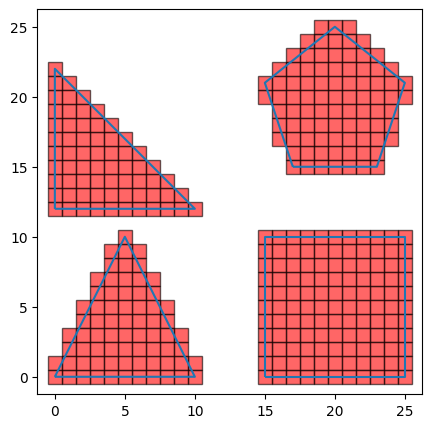

In [ ]:
fig, ax = plt.subplots(figsize=(5,5))
ax = multipolygon_gdf.boundary.plot(ax = ax)
for idx, row in filled_polygons.to_pandas().iterrows():
    x = row["x"]
    y = row["y"]
    rect = patches.Rectangle(
                xy=(x - 0.5, y - 0.5),
                width=1,
                height=1,
                linewidth=1,
                edgecolor="black",
                facecolor="r",
                alpha=0.6,
            )
    ax.add_patch(rect)
plt.show()

## Error Correction using Off-Boundary Pixels

Off-boundary pixels are pixels that have at least one corner tangential to an AOI polygon's edge. They are useful for gridding error correction in [FastSquareGridGenerator](https://geowrangler.thinkingmachin.es/grids.html#fastsquaregridgenerator) and [FastBingTileGridGenerator](https://geowrangler.thinkingmachin.es/grids.html#fastbingtilegridgenerator). 

When we translate a polygon from geographic coordinates to pixel coordinates, we inevitably have to round the polygon vertex coordinates to the nearest higher or lower integer. For some pixels, this rounding results in the translated polygon boundary to be tangent to one of the pixel's corners. But if it were in the original geographic coordinates, the boundary would have had intersected a portion of the pixel's interior.

Thus, there will sometimes be pixels that when in geographic coordinates actually intersect the AOI, but when in pixel coordinates are only tangential to the AOI polygon. When we use the fast polygon fill algorithm, it doesn't consider these tangential pixels, also called off-boundary pixels, as part of the filled-in pixel set. So to correct this error, we need to first identify the off-boundary pixels and then select which ones to add to the filled-in pixel set.

### How do we implement error correction?

We determine which pixels to add to the filled-in pixel set by intersecting the polygon boundary linestring with the off-boundary pixel polygon. Both the linestring and the off-boundary pixel polygon should be in geographic coordinates, not pixel coordinates. The pixels that intersect should be added to the filled-in pixel set. You can find this implementation in the `generate_grid` method under [FastSquareGridGenerator](https://geowrangler.thinkingmachin.es/grids.html#fastsquaregridgenerator) and [FastBingTileGridGenerator](https://geowrangler.thinkingmachin.es/grids.html#fastbingtilegridgenerator)

- *Why can't we just add all of the off-boundary pixels?* We can't because not all of the off-boundary pixels actually intersect the polygon when in geographic coordinates. 

- *Won't there be an increased computational cost from using a geometry intersection operation?* Yes, this additional step will add compute time but the increase in computational cost should be minimal since we're doing a linestring to polygon intersection (not a polygon to polygon intersection), and the off-boundary pixels should be a small fraction of the total pixels.

- *Why is error correction not implemented in this notebook?* In this particular notebook we're only working with pixel coordinates, so the translation problem isn't a concern and we don't need error correction. It's a concern when you're starting off with geographic coordinates, as shown in [FastSquareGridGenerator](https://geowrangler.thinkingmachin.es/grids.html#fastsquaregridgenerator) and [FastBingTileGridGenerator](https://geowrangler.thinkingmachin.es/grids.html#fastbingtilegridgenerator). 


The section below demonstrates the utility functions for getting off-boundary pixels

1. Get off-diagonal pixels for a single polygon using `voxel_traversal_2d`
2. Get off-boundary pixels for a single polygon using `voxel_traversal_scanline_fill`
3. Get off-boundary pixels for a GeoDataFrame using `fast_polygon_fill`

### Off-Diagonal Pixels 

Off-boundary pixels originate from off-diagonal pixels. Off-diagonal pixels occur whenever there is a diagonal step in the voxel traversal algorithm (hence the name).  

Notice below that some of the off-diagonal pixels are in the interior. Later in the `voxel_travresal_scanline_fill` function we'll be filtering these further to include only off-diagonal pixels on the polygon's exterior. The filtered pixels are the off-boundary pixels.

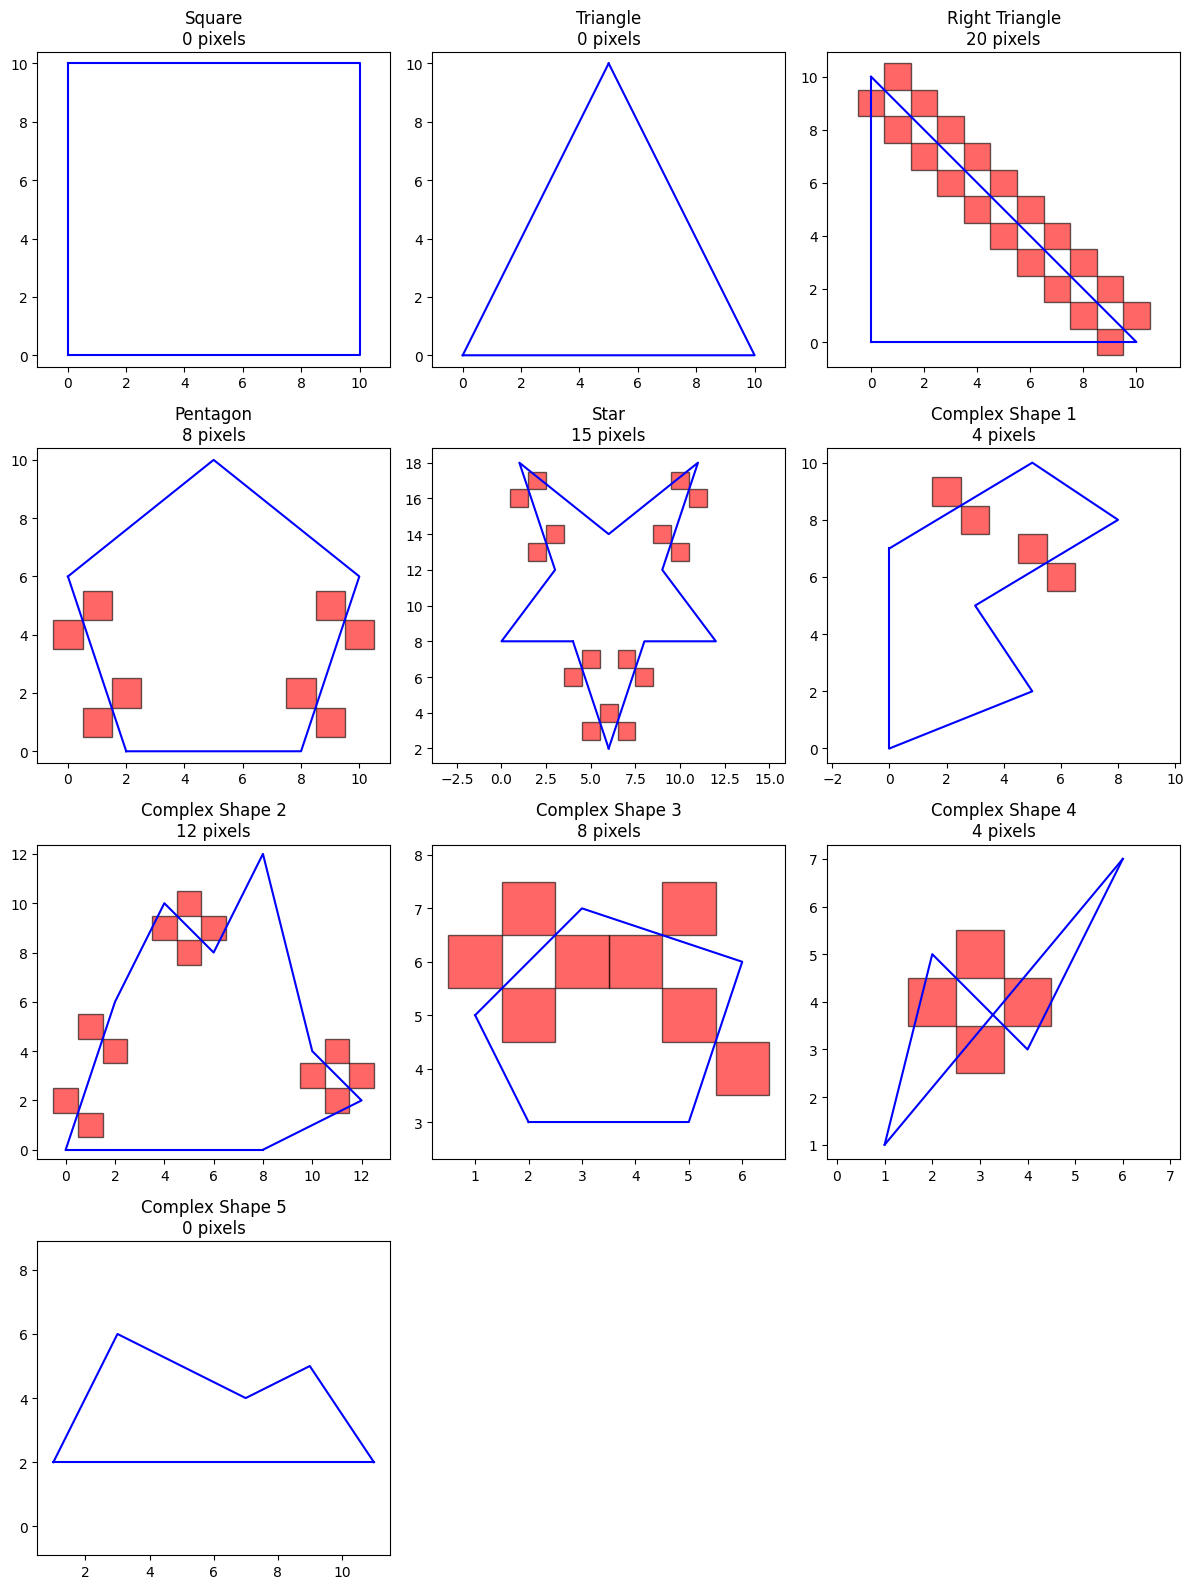

In [ ]:
off_diagonal_pixels = {}
for test_polygon_name, vertices in polygon_test_cases.items():
    offset_vertices = vertices[1:] + vertices[:1]

    pixels = set()
    for start_vertex, end_vertex in zip(vertices, offset_vertices):
        pixels.update(voxel_traversal_2d(start_vertex, end_vertex)["off_diagonal_pixels"])

    off_diagonal_pixels[test_polygon_name] = pixels
    
plot_all_polygons(polygon_test_cases, off_diagonal_pixels)

### Off-Boundary Pixels

Off-boundary pixels are almost the same as the off-diagonal pixels, just filtered to only include pixels on the polygon exterior. These are what we use for gridding error correction.

Inside `voxel_traversal_scanline_fill`, the filtering is done by getting the set difference between the the off-boundary pixels and the interior pixels from scanline fill.

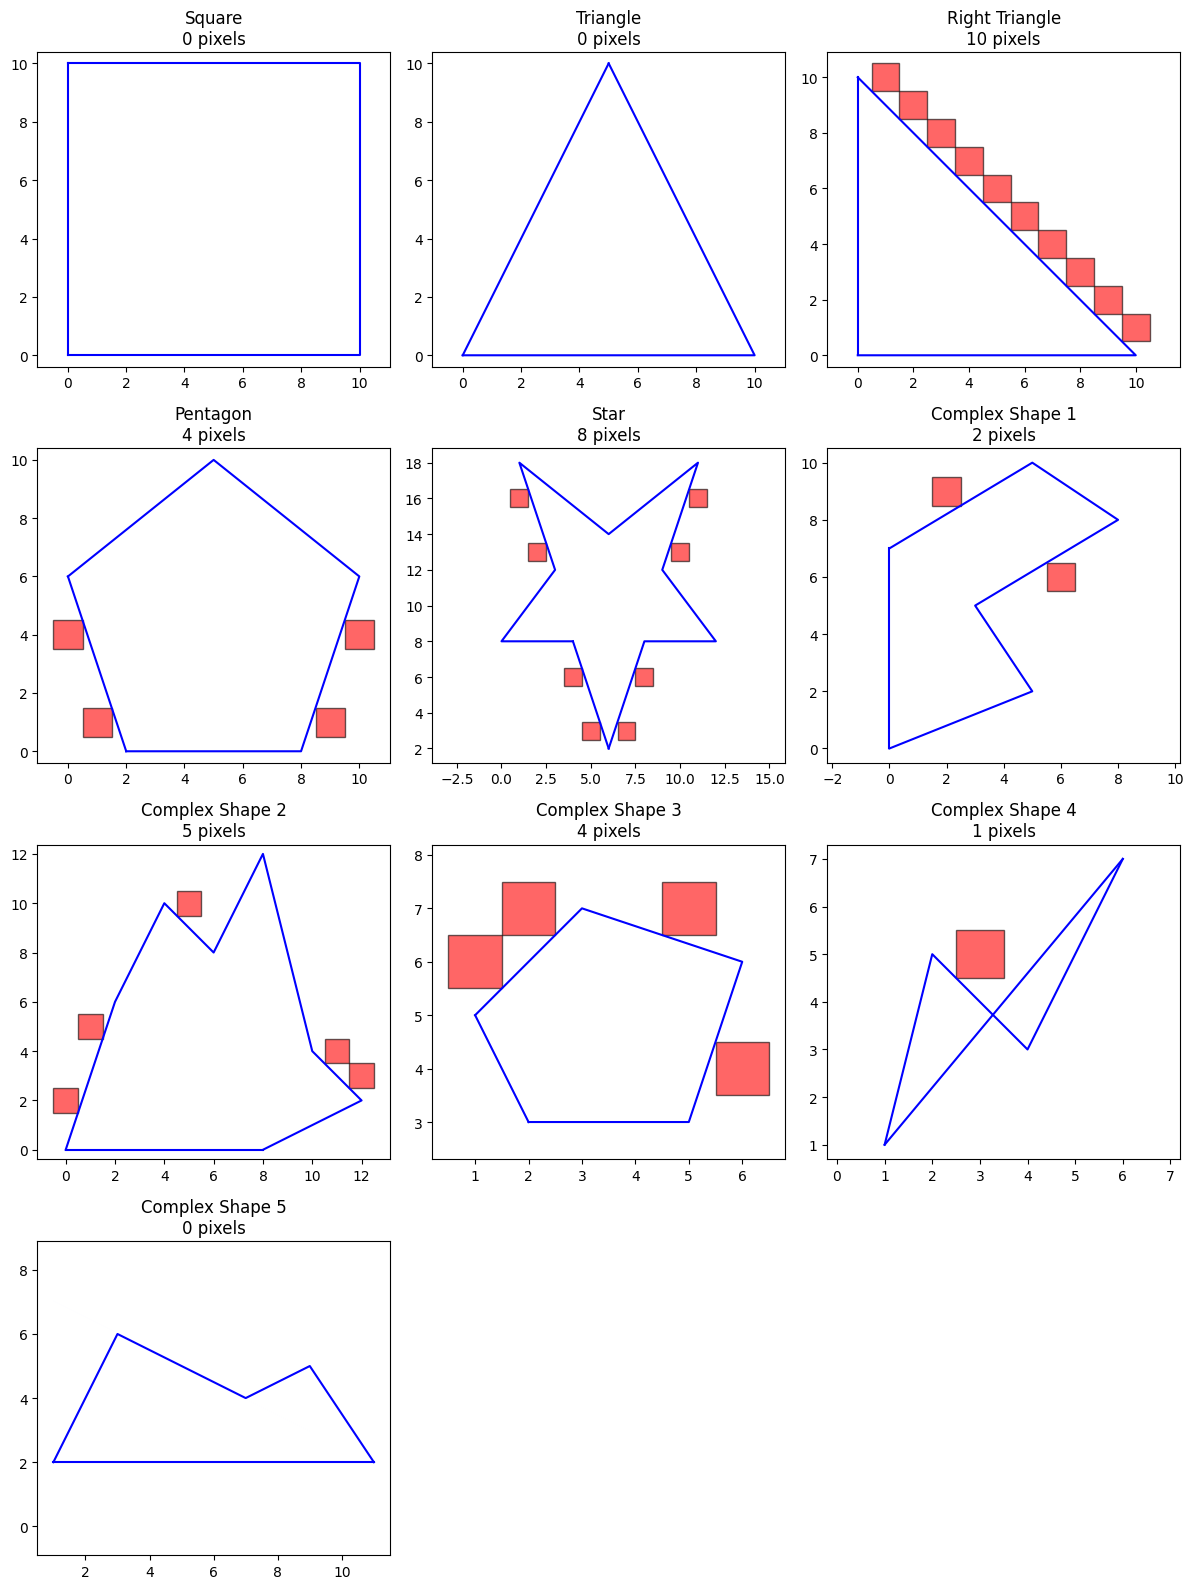

In [ ]:
off_boundary_pixels = {}
for test_polygon_name, vertices in polygon_test_cases.items():
    vertices_df = pd.DataFrame(vertices, columns=["x", "y"])
    off_boundary_pixels[test_polygon_name] = voxel_traversal_scanline_fill(vertices_df)["off_boundary_pixels"]
    
plot_all_polygons(polygon_test_cases, off_boundary_pixels)

### Putting it all together to get off-boundary pixels of a GeoDataFrame

The `fast_polygon_fill` function also returns the off-boundary pixels across all geometries in a GeoDataFrame

In [ ]:
multipolygon_gdf.head()

,geom_name,geometry
0,Square,"POLYGON ((15 0, 25 0, 25 10, 15 10, 15 0))"
1,Triangle MultiPolygon,"MULTIPOLYGON (((0 0, 10 0, 5 10, 0 0)), ((0 12..."
2,Pentagon,"POLYGON ((17 15, 23 15, 25 21, 20 25, 15 21, 1..."


In [ ]:
vertices_df = polygons_to_vertices(multipolygon_gdf, "geom_name")
vertices_df = vertices_df.cast({"x":PIXEL_DTYPE, "y":PIXEL_DTYPE})

tiles_off_boundary = fast_polygon_fill(vertices_df, "geom_name")["tiles_off_boundary"]
tiles_off_boundary.head()

x,y,geom_name
i32,i32,str
9,14,"""Triangle MultiPolygon"""
24,16,"""Pentagon"""
2,21,"""Triangle MultiPolygon"""
6,17,"""Triangle MultiPolygon"""
10,13,"""Triangle MultiPolygon"""


In [ ]:
# counting pixels per geometry
tiles_off_boundary.group_by("geom_name").len()

geom_name,len
str,u32
"""Pentagon""",4
"""Triangle MultiPolygon""",10


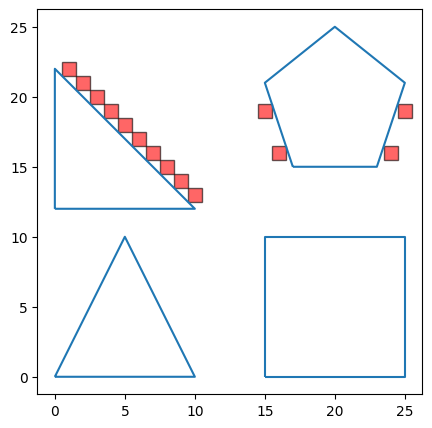

In [ ]:
fig, ax = plt.subplots(figsize=(5,5))
ax = multipolygon_gdf.boundary.plot(ax = ax)
for idx, row in tiles_off_boundary.to_pandas().iterrows():
    x = row["x"]
    y = row["y"]
    rect = patches.Rectangle(
                xy=(x - 0.5, y - 0.5),
                width=1,
                height=1,
                linewidth=1,
                edgecolor="black",
                facecolor="r",
                alpha=0.6,
            )
    ax.add_patch(rect)
plt.show()